# Notebook 3: Estimating Proportions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [4]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [5]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

## Estimating proportions

In *Information Theory, Inference, and Learning Algorithms*, David MacKay poses this problem:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  'It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  'If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

To answer that question, we'll use the observed data to estimate the probability that the coin comes up heads.

But I'll start with the binomial distribution.

## Binomial distribution

Suppose we know for sure that the coin is fair, that is, that the probability of heads is exactly 50%.
If we spin it on edge 250 times, we expect the number of heads to follow a binomial distribution with parameters `n=250` and `p=0.5`.

And we can use PyMC to generate a sample of values from that distribution.

In [6]:
import pymc3 as pm

n = 250
p = 0.5
sample_binomial = pm.Binomial.dist(n, p).random(size=1000)
sample_binomial.mean()

125.357

Here's what the distribution of the sample looks like.

In [7]:
def decorate_heads(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of heads (k)')
    plt.ylabel(ylabel)
    plt.title('Distribution of heads')
    legend()

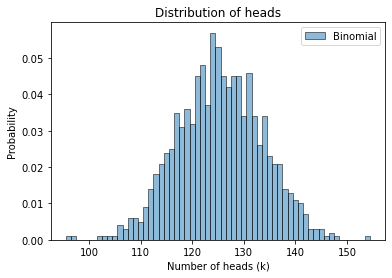

In [8]:
plot_hist(sample_binomial, label='Binomial')
decorate_heads()

## The beta distribution

In the previous section I assumed that the actual probability of heads is known, but in general it is not.
And for the Euro problem, the probability of heads is what we would like to estimate.

So, just as we used a gamma distribution to represent possible values for the goal scoring rate, `mu`, now we will use a beta distribution to represent possible values for the probability of heads, which I will call `x`.

The beta distribution is not the only possibility, but it is continuous and defined for values between 0 and 1 (including both) so it is appropriate for values that are probabilities.

The shape of the beta distribution is controlled by two parameters, called `alpha` and `beta`. 

In [9]:
alpha = 2
beta = 2

And we can use PyMC to draw a sample from a beta distribution with given parameters.

In [10]:
sample_beta = pm.Beta.dist(alpha=alpha, beta=beta).random(size=1000)
sample_beta.mean()

0.5035637876384826

Here's what the beta distribution looks like with `alpha=2` and `beta=2`.

In [11]:
def decorate_proportion(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel(ylabel)
    plt.title('Distribution of proportion')
    legend()

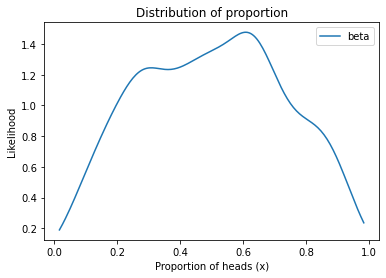

In [12]:
plot_kde(sample_beta, label='beta')
decorate_proportion()

**Exercise:** See what the distribution looks like with different values of `alpha` and `beta`.

## The Beta-Binomial model

To model the coin-spinning process, I'll draw values of `x` from a beta distribution and then draw values of `k` from a binomial distribution.

Remember that `x` is the probability of heads, which is a continuous value between 0 and 1, and `k` is the number of heads, which is an integer between 0 and `n`.

Here's what the model looks like in PyMC

In [13]:
alpha = 2
beta = 2
n = 250

In [14]:
with pm.Model() as model1:
    x = pm.Beta('x', alpha=alpha, beta=alpha)
    k = pm.Binomial('k', n=n, p=x)
    trace1 = pm.sample_prior_predictive(1000)

The variables `x` and `k` are connected because the value of `x` is a parameter for the distribution of `k`.

Here's the graphical representation that shows this connection.


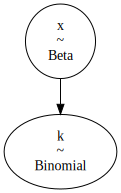

In [15]:
pm.model_to_graphviz(model1)

From the trace we can extract `x`, which is a sample from the prior distribution.

In [16]:
sample_prior = trace1['x']
sample_prior.mean()

0.500621431767405

Here's what it looks like.

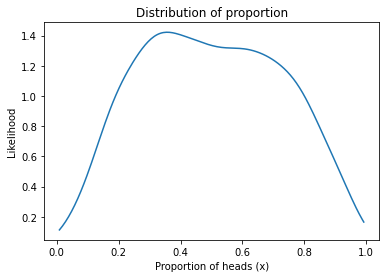

In [17]:
plot_kde(sample_prior)
decorate_proportion()

This distribution represents a belief about coins; specifically, it suggests that most coins are close to fair, with values of `x` between 0.4 and 0.6, but some coins are strongly biased, with values of `x` near 0 and 1.

In reality, I suspect that coins are not really as variable as this; I can imagine that `x` might be as low as 0.4 or as high as 0.6, but I would be surprised if it were much outside that range.

So this prior might not represent everything we know about coins, but in this example it turns out not to affect the result very much.

## The prior predictive distribution

From the same trace we can extract `k`, which is the prior predictive distribution.
It represents the number of heads we expect, with `n=250`, based on the prior distribution of `x`.

In [18]:
sample_prior_pred = trace1['k']
sample_prior_pred.mean()

124.875

Here's what the distribution looks like.

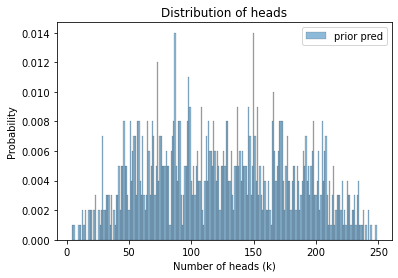

In [19]:
plot_hist(sample_prior_pred, label='prior pred')
decorate_heads()

If we believe what the prior distribution says about `x`, this is what we should believe about `k`.

Now let's use the data to update it.

## Estimation

From the previous model, it is a small change to draw a sample from the posterior distribution of `x`.

In [20]:
k_obs = 140

with pm.Model() as model2:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace2 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


The trace contains a sample of values from the posterior distribution of `x`.

In [21]:
len(trace2['x'])

2000

We can use `plot_trace` to see if the sampler ran into any problems.

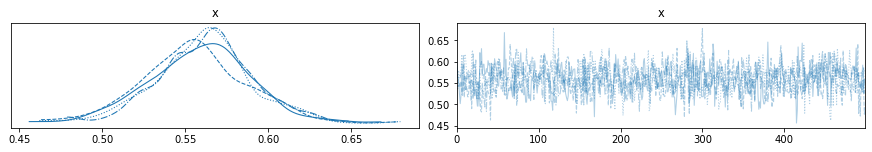

In [22]:
import arviz as az

with model2:
    az.plot_trace(trace2)

And `plot_posterior` to see the posterior distribution.

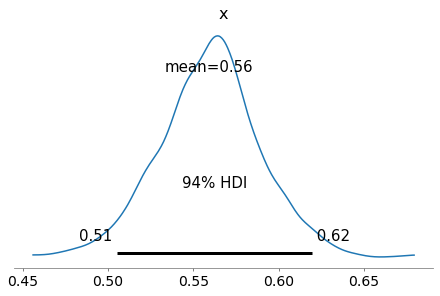

In [23]:
with model2:
    az.plot_posterior(trace2)

Again, the 94% HDI is a credible interval that have a 94% chance of containing the true value of `x` for this coin.

## The posterior predictive distribution

In this example, we are primarily interested in estimating `x`, but we can also use the posterior predictive distribution to predict what would happen if we spun the same coin again.

In [24]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

The result is a trace that contains a sample of values for `k`.

In [25]:
sample_post_pred = post_pred['k']
sample_post_pred.mean()

140.0175

And here's what it looks like.

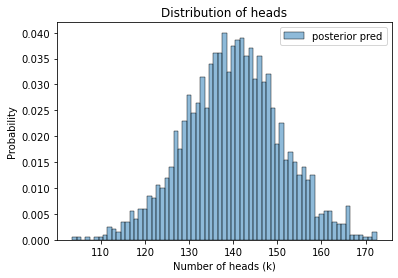

In [26]:
plot_hist(sample_post_pred, label='posterior pred')
decorate_heads()